In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import scipy as sp
from scipy.sparse import kron, eye, diags
import math as mt

# **Exercise 2a: Newton-Raphson for non-linear system**

In [14]:
""" INITIAL GUESS """
def initial_guess(x):
    xbar = 0.5 * (a-b-alpha+beta)
    w_0 = 0.5 * (a+b-alpha-beta)
    return x - xbar + w_0*np.tanh(w_0*(x-xbar)/(2*eps))

In [15]:
""" COMPUTE G """
def G(u):
    N = len(u)
    G = np.zeros(N)
    for i in range(N):
        u_i = u[i]
        u_prev = u[i-1] if i>0 else alpha
        u_next = u[i+1] if i<N-1 else beta
    
        # Update G function
        G[i] = (eps/h**2) * (u_next-2*u_i+u_prev) + u_i * ((u_next-u_prev)/(2*h) - 1)
    
    return G

In [16]:
""" JACOBIAN """
def J(u):
    N = len(u)
    J = np.zeros((N,N))
    
    for i in range(N):
        u_i = u[i]
        u_prev = u[i-1] if i>0 else alpha
        u_next = u[i+1] if i<N-1 else beta
        
        # Diagonal
        J[i,i] = -2*eps/h**2 + 1/(2*h) * (u_next-u_prev) - 1
        
        # Off diagonal up
        if i < N-1:
            J[i,i+1] = eps/h**2 + u_i/(2*h)
        
        # Off diagonal down
        if i > 0:
            J[i,i-1] = eps/h**2 - u_i/(2*h)
        
    return J

In [17]:
""" Newton-Raphson """
def Newton_Raphson_Systems(G,J,u0,tol=1e-7,num_iter=100):
    u = u0.copy()
    iteration = 0
    
    while iteration < num_iter:
        jacobian = J(u)
        Fu = G(u)
        du = np.linalg.solve(jacobian, -Fu)
        
        u_new = u + du
        
        if np.linalg.norm(du, 2) < tol:            
            print(f"Newton-Raphson converged in {iteration+1} iterations.")
            return u_new
        
        iteration =+ 1
        u = u_new
        
    print("Newton-Raphson did not converge.")
    return u_new

In [18]:
# Parameters
epsilon = np.array([.1,.3,.5,.8,1])
alpha = -1
beta = 1.5

# Domain
a = 0
b = 1

""" Mesh Construction """
N = 30  # Interior points
h = (b-a)/(N+1)
xi = np.arange(a,b+h,h)

In [19]:
# Initial Solution
eps = epsilon[0]
u0 = initial_guess(xi)[1:-1]
# Solution interior points
u_interior = Newton_Raphson_Systems(G, J, u0)
# Complete solution
u_sol = np.concatenate(([alpha], u_interior, [beta]))

Newton-Raphson converged in 2 iterations.


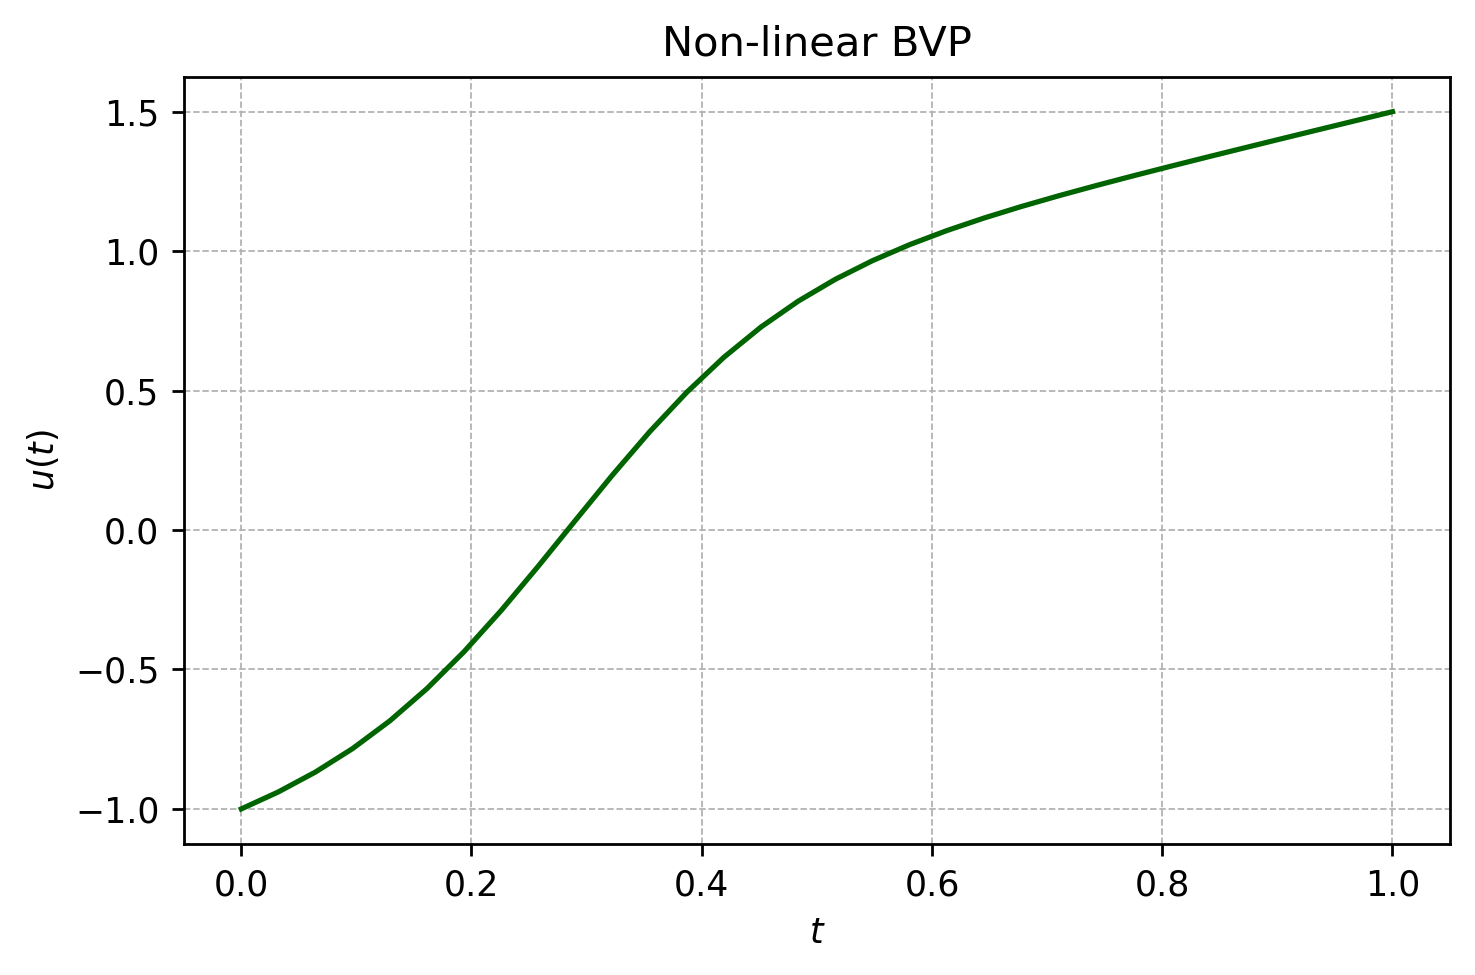

In [20]:
# Plots
fig = plt.figure(figsize=(6,4),dpi=250)
axes = plt.gca()
axes.plot(xi,u_sol,color='darkgreen',label='Solution')
#axes.plot(xi,initial_guess(xi),linestyle='--',color='slategray',label='Initial Guess')
axes.set_xlabel(r'$t$')
axes.set_ylabel(r'$u(t)$')
axes.set_title('Non-linear BVP')
axes.grid(True, linestyle="--",linewidth=0.5)
#axes.legend()

plt.tight_layout()
# fig.savefig('Assignement1_2b.png', bbox_inches='tight')

In [21]:
U = np.zeros((N+2,len(epsilon)))
for k, eps in enumerate(epsilon):
    """ Approximate initial solution """
    u0 = initial_guess(xi)[1:-1]
    # Solution interior points
    u_interior = Newton_Raphson_Systems(G, J, u0)
    u_sol = np.concatenate(([alpha], u_interior, [beta]))
    # save each solution
    U[:,k] = u_sol

Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.
Newton-Raphson converged in 2 iterations.


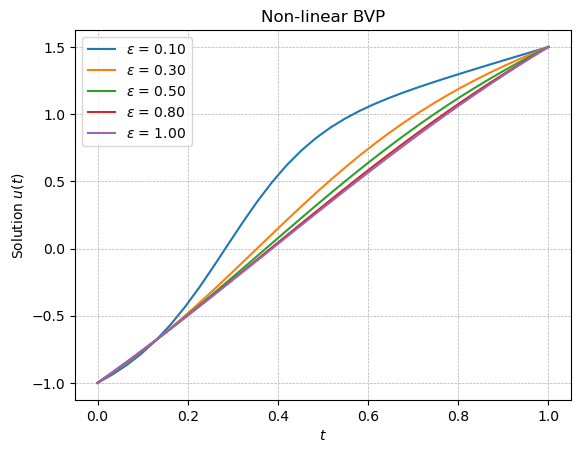

In [22]:
# Plots
fig = plt.figure()
axes = plt.gca()
for k in range(len(epsilon)):
    axes.plot(xi,U[:,k],label=rf'$\epsilon$ = {epsilon[k]:.2f}')

axes.set_xlabel(r'$t$')
axes.set_ylabel(r'Solution $u(t)$')
axes.set_title('Non-linear BVP')
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)
# fig.savefig('Assignement1_2b.png', bbox_inches='tight')

# **Exercise 2b: 5- and 9-point Laplacian**

## **2b-c: 5-point**

In [23]:
# System Matrix for 5-point stencil (interior points)
def poisson5(m):
    e = np.ones(m)
    S = diags([e, -2*e, e], [-1, 0, 1], shape=(m, m))
    I = eye(m)
    A = kron(I, S) + kron(S, I)
    A = (m + 1) ** 2 * A
    return A

# Laplacian of the exact solution
def analytical_laplacian(x, y):
    pi = np.pi
    return -32 * pi**2 * np.sin(4 * pi * (x + y)) - 16 * pi**2 * (x**2 + y**2) * np.cos(4 * pi * x * y)

# Exact solution
def exact_solution(x, y):
    pi = np.pi
    return np.sin(4 * pi * (x + y)) + np.cos(4 * pi * x * y)

# Include BC in the right-hand side f
def f_BC_5p(f,h,u_exact):
    # 5 point nodes coefficients
    main_coeff = 1/h**2
    # Left boundary
    f[1:m+1, 1] = f[1:m+1, 1] - main_coeff * u_exact[1:m+1, 0]
    # Right boundary
    f[1:m+1, m] = f[1:m+1, m] - main_coeff * u_exact[1:m+1, m+1]
    # Bottom boundary
    f[1, 1:m+1] = f[1, 1:m+1] - main_coeff * u_exact[0, 1:m+1]
    # Top boundary
    f[m, 1:m+1] = f[m, 1:m+1] - main_coeff * u_exact[m+1, 1:m+1]
    return f

In [24]:
# Mesh
m = 100
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)

X, Y = np.meshgrid(x, y)
# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Extract only the interior points
f_complete = f_BC_5p(f,h,u_exact) 
f = f_complete[1:-1, 1:-1]

# Construct the matrix A
sparse_A = poisson5(m)
#A_array = sparse_A.toarray()

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
#u_app = np.linalg.solve(A_array, f_flatten)

# Solve system with sparse matrix
u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = U - u_exact
error = np.abs(error)

### Solution

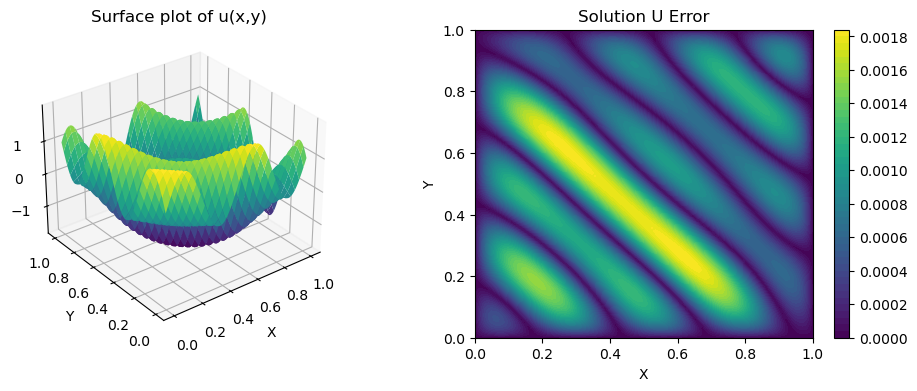

In [25]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('Surface plot of u(x,y)')



# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Solution U Error')

# Save figur
# fig.savefig('2b_c_Solution.png', bbox_inches='tight', dpi=200)

#plt.tight_layout()

plt.show()

### Convergence Test. Second-Order accuracy

In [26]:
s = np.arange(3,10+1,1)
h_values = 1/(2**s)
m_values = (1/h_values - 1).astype('int')

# Initialize max norm error for each h_value
error_total_5p = np.zeros(len(h_values))

for i, h in enumerate(h_values):
    m = (1/h - 1).astype('int')
    x = np.linspace(0, 1, m+2)
    y = np.linspace(0, 1, m+2)
    
    X, Y = np.meshgrid(x, y)
    
    # Compute exact solution and Laplacian
    u_exact = exact_solution(X, Y)
    exact_laplacian = analytical_laplacian(X, Y)

    # Construct right-hand side (vectorized)
    f = exact_laplacian.copy()
    
    # Extract only the interior points
    f_complete = f_BC_5p(f,h,u_exact) 
    f = f[1:-1, 1:-1]
    
    # Construct the matrix A
    sparse_A = poisson5(m)
    #A_array = sparse_A.toarray()
    
    # Flatten to match dimensionality
    f_flatten = f.flatten('F')
    
    # Solve system
    u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)
    
    # Fill the full grid with computed values
    U = u_exact.copy()
    U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')
    
    # Compute error
    error = U[1:-1,1:-1] - u_exact[1:-1,1:-1]

    # Total error
    error_total_5p[i] = np.max(np.abs(error))

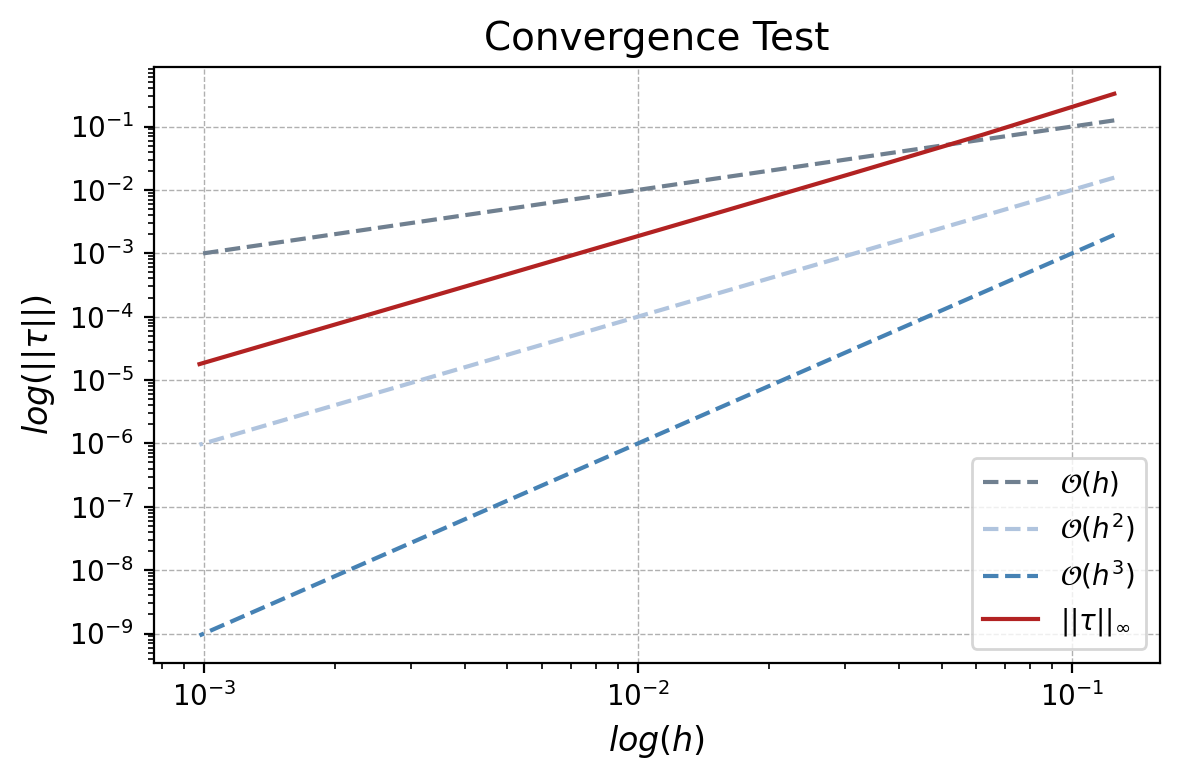

In [27]:
fig = plt.figure(figsize=(6,4),dpi=200)
axes = plt.gca()

axes.loglog(h_values, h_values**1, linestyle='--', label=r'$\mathcal{O}(h)$',color='slategrey')
axes.loglog(h_values, h_values**2, linestyle='--', label=r'$\mathcal{O}(h^2)$', color='lightsteelblue')
axes.loglog(h_values, h_values**3, linestyle='--', label=r'$\mathcal{O}(h^3)$', color='steelblue')
axes.loglog(h_values, error_total_5p, linestyle='-', label=r'$||\tau||_{\infty}$', color='firebrick')
axes.set_xlabel(r'$log(h)$',fontsize=12)
axes.set_ylabel(r'$log(||\tau||)$',fontsize=12)
axes.set_title('Convergence Test',fontsize=14)
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)
plt.tight_layout()

#fig.savefig('2b_c_Convergence.png', bbox_inches='tight', dpi=200)

## **2b-d: 9-point Deferred Correction**

In [28]:
def poisson9(m):
    e = np.ones(m)
    S = diags([-e, -10*e, -e], [-1, 0, 1], shape=(m, m))
    I = diags([-1/2*e, e, -1/2*e], [-1, 0, 1], shape=(m, m))
    A = kron(I, S) + kron(S, I)
    A = 1/6*(m + 1) ** 2 * A
    return A

# Laplacian of the exact solution
def analytical_laplacian(x, y):
    pi = np.pi
    # return 0 + 0*x*y
    return -32 * pi**2 * np.sin(4 * pi * (x + y)) - 16 * pi**2 * (x**2 + y**2) * np.cos(4 * pi * x * y)

# Exact solution
def exact_solution(x, y):
    pi = np.pi
    # return 1+ 1*x
    return np.sin(4 * pi * (x + y)) + np.cos(4 * pi * x * y)

# Compute Laplacian of f for deferred correction
def laplacian_f(x,y):
    pi = np.pi
    return 64*pi**2*(4*pi**2*x**4*np.cos(4*pi*x*y) + 8*pi**2*x**2*y**2*np.cos(4*pi*x*y) + 8*pi*x*y*np.sin(4*pi*x*y) + 4*pi**2*y**4*np.cos(4*pi*x*y) + 16*pi**2*np.sin(pi*(4*x + 4*y)) - np.cos(4*pi*x*y))

    
# Apply boundary conditions (vectorized) ADAPT TO 9 LAPLACIAN
def f_BC_9pt(f, h, u_exact):
    
    # 9-point nodes coefficients
    main_coeff = 4/(6*h**2)
    diag_coeff = 1/(6*h**2)
    
    # Left boundary
    f[1:m+1, 1] = f[1:m+1, 1] - main_coeff * u_exact[1:m+1, 0]
    f[1:m+1, 1] = f[1:m+1, 1] - diag_coeff * (u_exact[0:m, 0] + u_exact[2:m+2, 0])
    
    # Right boundary
    f[1:m+1, m] = f[1:m+1, m] - main_coeff * u_exact[1:m+1, m+1]
    f[1:m+1, m] = f[1:m+1, m] - diag_coeff * (u_exact[0:m, m+1] + u_exact[2:m+2, m+1])
    
    # Bottom boundary
    f[1, 1:m+1] = f[1, 1:m+1] - main_coeff * u_exact[0, 1:m+1]
    f[1, 1:m+1] = f[1, 1:m+1] - diag_coeff * (u_exact[0, 0:m] + u_exact[0, 2:m+2])
    
    # Top boundary
    f[m, 1:m+1] = f[m, 1:m+1] - main_coeff * u_exact[m+1, 1:m+1]
    f[m, 1:m+1] = f[m, 1:m+1] - diag_coeff * (u_exact[m+1, 0:m] + u_exact[m+1, 2:m+2])
    
    # # TERM IN THE CORNERS
    f[1,1] += diag_coeff * u_exact[0,0]
    f[m,m] += diag_coeff * u_exact[m+1,m+1]
    f[1,m] += diag_coeff * u_exact[0,m+1]
    f[m,1] += diag_coeff * u_exact[m+1,0]

    return f

In [29]:
# Mesh
m = 50
h = 1 / (m + 1)
x = np.linspace(0, 1, m+2)
y = np.linspace(0, 1, m+2)
X, Y = np.meshgrid(x, y)

# Compute exact solution and Laplacian
u_exact = exact_solution(X, Y)
exact_laplacian = analytical_laplacian(X, Y)

# Construct right-hand side (vectorized)
f = exact_laplacian.copy()

# Apply boundary conditions
f_complete = f_BC_9pt(f, h, u_exact)


# Apply deferred correction
f_corrected = f_complete + (h**2 / 12) * laplacian_f(X, Y)

# Extract only the interior points
f = f_corrected[1:-1, 1:-1]

# Construct the matrix A
sparse_A = poisson9(m)

# Flatten to match dimensionality
f_flatten = f.flatten('F')

# Solve system
u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)

# Fill the full grid with computed values
U = u_exact.copy()
U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')

# Compute error
error = np.abs(U - u_exact)

### Solution

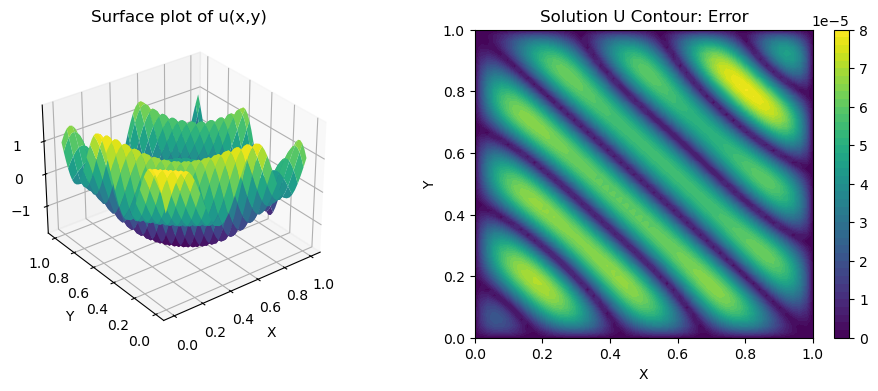

In [30]:
# Create figure with 2 columns
fig = plt.figure(figsize=(12, 4), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.2)

# ----- Subplot 1: 3D Surface Plot -----
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.plot_surface(X, Y, U, cmap='viridis')

# Reverse axes for MATLAB-like orientation
ax1.set_xlim(ax1.get_xlim()[::-1])  
ax1.set_ylim(ax1.get_ylim()[::-1])  

# Set view to match MATLAB
ax1.view_init(elev=30, azim=90-37.5)

# Labels
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('u(X,Y)')
ax1.set_title('Surface plot of u(x,y)')



# ----- Subplot 2: Contour Plot -----
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, error, levels=50, cmap='viridis')
fig.colorbar(contour, ax=ax2)  # Add colorbar
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Solution U Contour: Error')

# Save figur
# fig.savefig('2b_c_Solution.png', bbox_inches='tight', dpi=200)

#plt.tight_layout()

plt.show()

### Convergence Test: Deferred Correction

In [31]:
s = np.arange(3,10+1,1)
h_values = 1/(2**s)
m_values = (1/h_values - 1).astype('int')

# Initialize max norm error for each h_value
error_total_9p = np.zeros(len(h_values))

for i, h in enumerate(h_values):
    m = (1/h - 1).astype('int')
    x = np.linspace(0, 1, m+2)
    y = np.linspace(0, 1, m+2)
    
    X, Y = np.meshgrid(x, y)
    
    # Compute exact solution and Laplacian
    u_exact = exact_solution(X, Y)
    exact_laplacian = analytical_laplacian(X, Y)

    # Construct right-hand side (vectorized)
    f = exact_laplacian.copy()
    
    # Extract only the interior points
    f_complete = f_BC_9pt(f, h, u_exact)
    f_corrected = f_complete + (h**2 / 12) * laplacian_f(X,Y)
    f = f_corrected[1:-1, 1:-1]
    
    # Construct the matrix A
    sparse_A = poisson9(m)
    #A_array = sparse_A.toarray()
    
    # Flatten to match dimensionality
    f_flatten = f.flatten('F')
    
    # Solve system
    u_app = sp.sparse.linalg.spsolve(sparse_A, f_flatten)
    
    # Fill the full grid with computed values
    U = u_exact.copy()
    U[1:-1, 1:-1] = u_app.reshape((m, m), order='F')
    
    # Compute error
    error = U[1:-1,1:-1] - u_exact[1:-1,1:-1]

    # Total error
    # error_total[i] = np.max(np.abs(error))
    error_total_9p[i] = np.linalg.norm((U - u_exact).flatten(), np.inf)

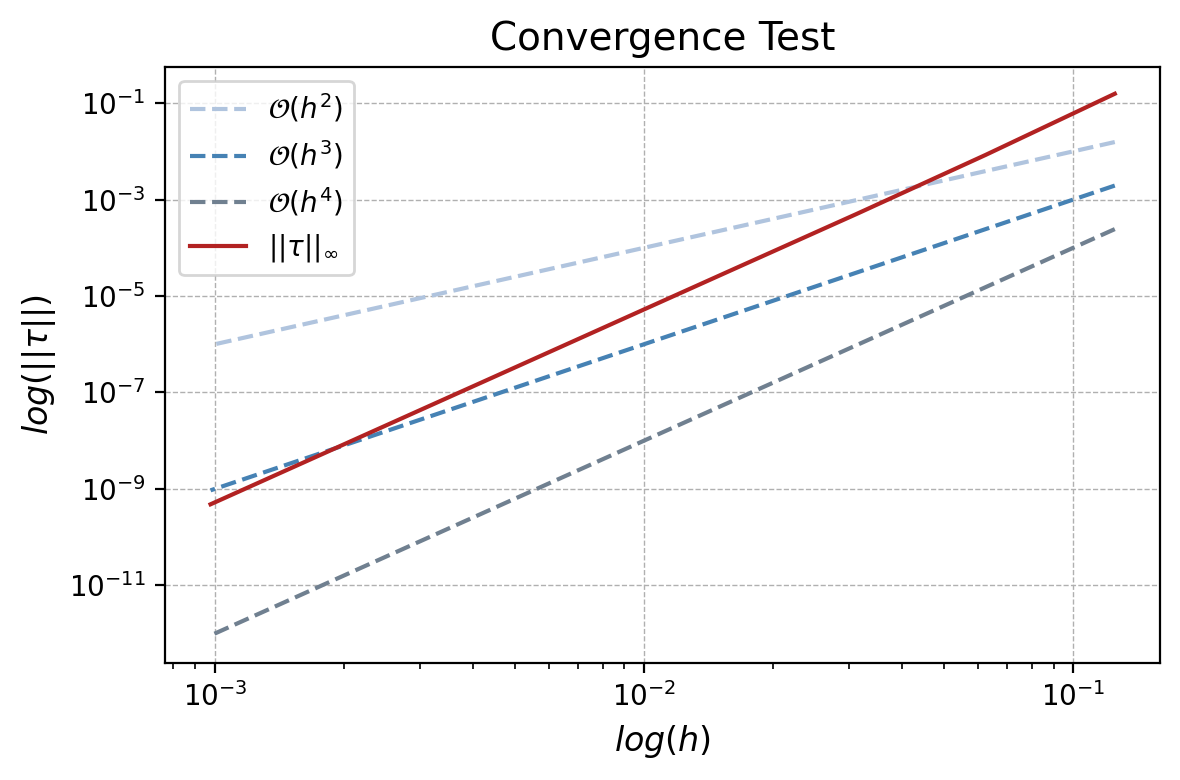

In [32]:
fig = plt.figure(figsize=(6,4),dpi=200)
axes = plt.gca()

axes.loglog(h_values, h_values**2, linestyle='--', label=r'$\mathcal{O}(h^2)$', color='lightsteelblue')
axes.loglog(h_values, h_values**3, linestyle='--', label=r'$\mathcal{O}(h^3)$', color='steelblue')
axes.loglog(h_values, h_values**4, linestyle='--', label=r'$\mathcal{O}(h^4)$', color='slategray')
axes.loglog(h_values, error_total_9p, linestyle='-', label=r'$||\tau||_{\infty}$', color='firebrick')
axes.set_xlabel(r'$log(h)$',fontsize=12)
axes.set_ylabel(r'$log(||\tau||)$',fontsize=12)
axes.set_title('Convergence Test',fontsize=14)
axes.legend()
axes.grid(True, linestyle="--",linewidth=0.5)
plt.tight_layout()